# Data Model Hyperparameter Tuning
training a model to fit the data, using the final dataset created in 1.3 feature engineering. 
- Hyper parameter tuning with Logistic Regression and SVM (Since these two methods did the best) 
- Using RandomSearchCV, then narrowing it down with GridSearchCV
- Saving the Model as a pickle file. 

The data can be found here: https://www.kaggle.com/yasserh/breast-cancer-dataset

Documentation can be found here: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

You can also find the github repo here: https://github.com/brianl2/BrCancer_LHL_final



In [1]:
import pandas as pd 
import numpy as np 
import pickle 
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, roc_curve

In [2]:
#Defining functions from previous modeling notebooks: 

# oversampling to fix imbalance we observed previously.
sm = SMOTE(random_state=42)

def oversample(X, y):
    '''function for oversampling with SMOTE'''
    print(f'before resample: {y.shape}')
    xres, yres = sm.fit_resample(X, y)
    print(f'after resample: {yres.shape}')
    # Show the imbalance fixed 
    colors = sns.color_palette('pastel')[0:5]
    data = yres.value_counts()
    labels =['Resampled Benign Tumors','Resampled Malignant Tumors']
    #create pie chart
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()
    return xres,yres

# Function to prep the data for modeling
def prep_data(X, y):
    '''Oversamples the data, and then splits the data 80:20, then reshapes y values into a np.array (x,)'''
    # oversample the data
    x,y = oversample(X, y)
    # Split the data (80:20) ratio because we don't have much data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42) 
    #Scale / normalize the data
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    #Reshape y for modeling
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    return X_train, X_test, y_train, y_test

# Function for Evaluating
def evaluate(y_true,y_pred, test):
    ''' Prints out all evaluation scores and plots a confusion matrix'''
    print(f'accuracy: {accuracy_score(y_true,y_pred)}' )
    print(f'precision: {precision_score(y_true,y_pred)}')
    print(f'recall:{recall_score(y_true,y_pred)}')
    print(f'f1 score: {f1_score(y_true,y_pred)}')
    print(f'ROC_AUC score: {roc_auc_score(y_true,y_pred)}')
    # Confusion Matrix plot
    cm = confusion_matrix(y_true,y_pred)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v2}\n{v3}' for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    xtick = ['Malignant Pred' , 'Benign Pred']
    ytick = ['Malignant True' , 'Benign True']
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = xtick , yticklabels = ytick).set_title(f'Confusion Matrix for {test}', fontsize = 20);
    
# function for plotting ROC curves
def plot_roc_curve(y_true, y_pred, test):
    '''Function for plotting ROC Curve for evaluation'''
    #ROC curve plot for model
    fpr1, tpr1, thresh1 = roc_curve(y_true, y_pred[:], pos_label=1)
    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_true))]
    p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)
    # Plotting
    plt.style.use('seaborn')
    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label= test) # test conducted
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label = 'baseline') # baseline
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show();

In [3]:
# Read in Data
X = pd.read_csv('data/final_data.csv') 
y = pd.read_csv('data/final_target.csv')


before resample: (533, 1)
after resample: (686, 1)


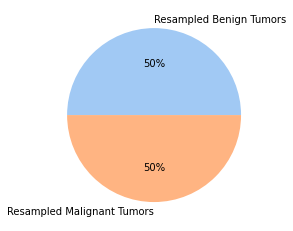

In [4]:
# Oversample with SMOTE + standardize data + Split Data
X_train, X_test, y_train, y_test =prep_data(X,y)

In [23]:
# Logistic regression, Random SearchCV
tic = time.perf_counter() # Start Time
LR = LogisticRegression(random_state=0)

#Parameter list
param_LR = {'penalty': ['l2'], #'l1', 'elasticnet'],
            'C': [.01, .1, 1, 5, 10, 100],
            'max_iter' : [100, 150, 200, 250, 300],
            'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
            'multi_class' : ['ovr']}

#fit RandomizedSearchCV
LR_modelRS = RandomizedSearchCV(LR, param_LR, random_state=0, cv = 5, n_jobs = -1, n_iter=50)
LR_RS = LR_modelRS.fit(X_train, y_train)

toc = time.perf_counter() # End Time

# printing time it took
print(f"Build finished in {(toc - tic)/60:0.0f} minutes {(toc - tic)%60:0.0f} seconds")

Build finished in 0 minutes 3 seconds


In [24]:
# Take the best model and predict with it. 
print(LR_RS.best_params_)
LRRS = LR_RS.best_estimator_
y_pred = LRRS.predict(X_test)

{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'max_iter': 200, 'C': 10}


accuracy: 0.9782608695652174
precision: 0.9852941176470589
recall:0.9710144927536232
f1 score: 0.9781021897810219
ROC_AUC score: 0.9782608695652173


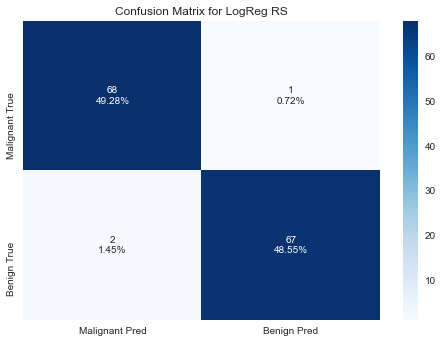

In [25]:
# check out the results
evaluate(y_test,y_pred, 'LogReg RS')

Very small improvement (from 97.10% to 97.83%) 
- Could try GridSearchCV next, but unlikely to have an improvement beyond this. 

In [26]:
# GridSearch for Logreg
tic = time.perf_counter() # Start Time
LR = LogisticRegression(random_state=0)

#Parameter list
param_LR = {'penalty': ['l2'],
            'C': np.linspace(10,100,90),
            'max_iter' : np.linspace(90, 150, num = 100),
            'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
            'multi_class' : ['ovr']}


LRGS = GridSearchCV(LR, param_LR, cv = 5, n_jobs = -1)
LRGS_model = LRGS.fit(X_train, y_train)

toc = time.perf_counter() # End Time
# printing time it took
print(f"Build finished in {(toc - tic)/60:0.0f} minutes {(toc - tic)%60:0.0f} seconds")

Build finished in 2 minutes 13 seconds


In [27]:
# Take the best model and predict with it. 
print(LRGS_model.best_params_)
LRGS2 = LRGS_model.best_estimator_
y_pred = LRGS2.predict(X_test)

{'C': 10.0, 'max_iter': 90.0, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}


accuracy: 0.9782608695652174
precision: 0.9852941176470589
recall:0.9710144927536232
f1 score: 0.9781021897810219
ROC_AUC score: 0.9782608695652173


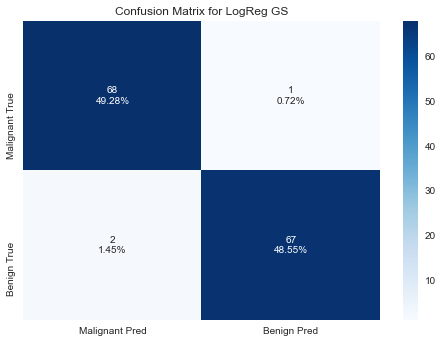

In [28]:
# check out the results
evaluate(y_test,y_pred, 'LogReg GS')

Same results as RandomSearch for GridSearch. 

In [29]:
tic = time.perf_counter() # Start Time
SVM_model = SVC(random_state = 0)

param_SVM = {"C": [.01, .1, 1, 5, 10, 100],             
             "gamma": [.01, .1, 1, 5, 10, 100],
             "kernel": ['rbf','linear', 'poly', 'sigmoid']
             }

SVMRS = RandomizedSearchCV(SVM_model, param_SVM , n_iter=144, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)
SVMRS_model = SVMRS.fit(X_train, y_train)

toc = time.perf_counter() # End Time
# printing time it took
print(f"Build finished in {(toc - tic)/60:0.0f} minutes {(toc - tic)%60:0.0f} seconds")

Build finished in 0 minutes 1 seconds


In [30]:
# Picking the best parameters to estimate. 
print(SVMRS_model.best_params_)
SVM_model2 = SVMRS_model.best_estimator_
y_pred2 = SVM_model2.predict(X_test)

{'kernel': 'rbf', 'gamma': 0.01, 'C': 100}


accuracy: 0.9637681159420289
precision: 0.9705882352941176
recall:0.9565217391304348
f1 score: 0.9635036496350365
ROC_AUC score: 0.9637681159420289


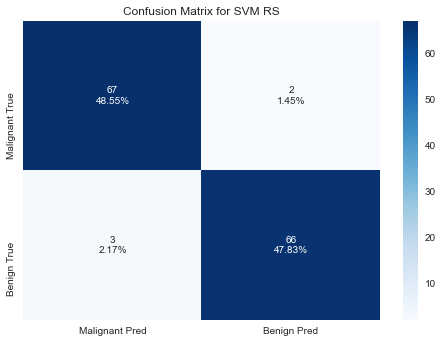

In [31]:
#check results
evaluate(y_test, y_pred2, 'SVM RS')

In [32]:
# GridSearch
tic = time.perf_counter() # Start Time
SVM_model = SVC(random_state = 0)

# Parameter list
param_SVM = {"C": np.linspace(0.1 , 100, num=50),             
             "gamma": [0.005 ,0.01, 0.015, 0.012, 0.011],
             "kernel": ['rbf','linear'],
             "random_state" : [0]}

#fit GridSearch
SVMGS = GridSearchCV(SVM_model, param_SVM , scoring='roc_auc', n_jobs=-1, cv=5)
SVMGS_model = SVMGS.fit(X_train, y_train)

toc = time.perf_counter() # End Time
# printing time it took
print(f"Build finished in {(toc - tic)/60:0.0f} minutes {(toc - tic)%60:0.0f} seconds")

Build finished in 0 minutes 3 seconds


In [33]:
# Picking the best parameters to estimate. 
print(SVMGS_model.best_params_)
SVMGSbest = SVMGS_model.best_estimator_
y_pred3 = SVMGSbest.predict(X_test)

{'C': 26.604081632653067, 'gamma': 0.015, 'kernel': 'rbf', 'random_state': 0}


accuracy: 0.9710144927536232
precision: 0.9710144927536232
recall:0.9710144927536232
f1 score: 0.9710144927536232
ROC_AUC score: 0.9710144927536232


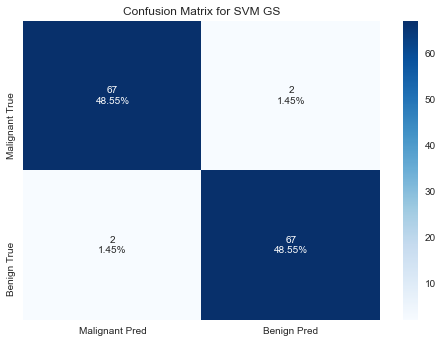

In [34]:
#check results
evaluate(y_test, y_pred3, 'SVM GS')

Despite Tuning, it looks like SVM works better with default parameters than with hypertuning. Overall SVM is the best performing Machine Learning model with 98.56% accuracy: 
- Below, we have the default parameters. 

accuracy: 0.9855072463768116
precision: 0.9855072463768116
recall:0.9855072463768116
f1 score: 0.9855072463768116
ROC_AUC score: 0.9855072463768115


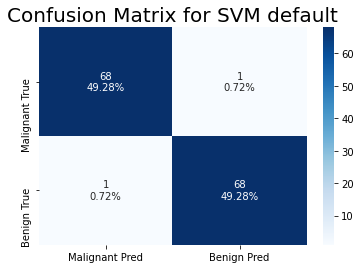

In [5]:
# default
SVM_model = SVC(probability=True).fit(X_train, y_train)
y_pred2 = SVM_model.predict(X_test)
evaluate(y_test, y_pred2, 'SVM default')

In [10]:
# Lets see what the default parameters are. 
SVM_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [109]:
# Saving the models that performed best as pickles.
filename = 'LogRegModel.sav'
pickle.dump(LRGS2, open(filename, 'wb'))

In [86]:
# Saving the models that performed best as pickles.
filename = 'SVM_Model.sav'
pickle.dump(SVM_model, open(filename, 'wb'))

## Lets plot the SVM plot and visualize the decision boundary
Must do PCA, to reduce dimensions from 8 to 2, (can't plot in 8 dimensions can we)

In [117]:
y_seq = list(y_train)

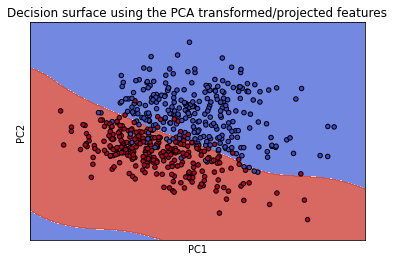

In [27]:
#Define functions for setting up the plot.
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X_train)

#Load in model 
loaded_model = pickle.load(open('SVM_Model.sav', 'rb'))
clf = loaded_model.fit(Xreduced, y_train)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)


plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decision surface using the PCA transformed/projected features')
plt.show()

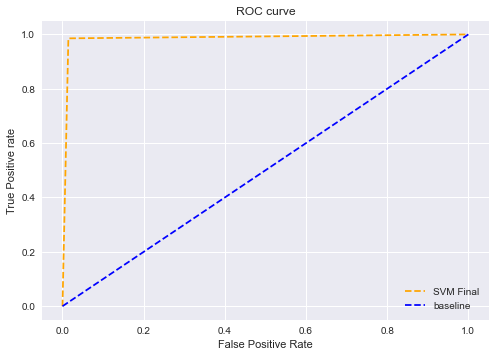

In [18]:
# ROC Curve for SVM
loaded_model = pickle.load(open('SVM_Model.sav', 'rb'))
loaded_model = loaded_model.fit(X_train, y_train)
y_pred = loaded_model.predict(X_test)
plot_roc_curve(y_test, y_pred, 'SVM Final')

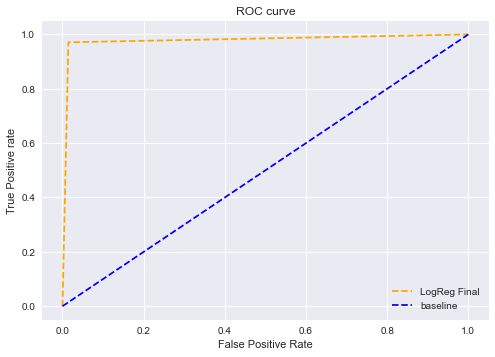

In [17]:
# ROC curve for Logreg
loaded_model2 = pickle.load(open('LogRegModel.sav', 'rb'))
loaded_model2 = loaded_model2.fit(X_train, y_train)
y_pred2 = loaded_model2.predict(X_test)
plot_roc_curve(y_test, y_pred2, 'LogReg Final')

In [12]:
X_train

array([[ 1.60527077,  1.05163546,  1.81921294, ...,  0.55563026,
         1.42721367,  0.64130495],
       [ 1.18391353, -0.62588105,  0.62645862, ...,  0.61629324,
         0.24237593, -0.08898183],
       [-0.00649434,  1.09145781, -0.55786634, ..., -0.80533051,
         0.31096277, -0.76814854],
       ...,
       [-0.56633963, -1.45717261, -0.75595628, ..., -0.27958468,
        -0.90816839, -1.04748324],
       [-0.44258436,  0.27509963, -1.07627193, ...,  0.26154669,
        -0.58752489, -0.69329415],
       [-0.59285862,  0.28007742, -0.34713236, ...,  2.72982664,
         0.41212837, -1.30856077]])

Text(0.5, 0, 'Permutation Importance')

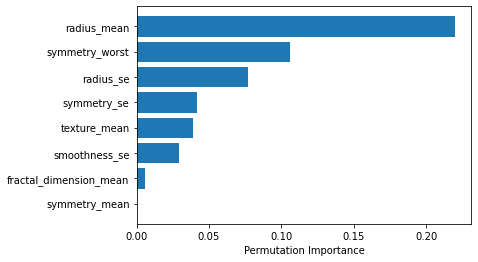

In [13]:
# checking feature importance
from sklearn.inspection import permutation_importance
#plot graph of feature importances for better visualization
perm_importance = permutation_importance(SVM_model, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")